In [1]:
import numpy as np
np.random.seed(42)
import torch
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
import random
random.seed(42)

from scene import Scene
import os
import subprocess
from tqdm import tqdm
from os import makedirs
from gaussian_renderer import render
import torchvision
from utils.general_utils import safe_state
from argparse import ArgumentParser
from arguments import ModelParams, PipelineParams, get_combined_args, pose_estimation_params
from gaussian_renderer import GaussianModel
from utils.image_utils import psnr
from utils.loss_utils import EdgeDetection
import numpy as np
from utils.loss_utils import l1_loss, ssim, l2_loss
from copy import deepcopy
from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity as LPIPS
import pypose as pp

from scene.dataset_readers import readColmapSceneInfo
from utils.camera_utils import loadCam
from collections import namedtuple
from matplotlib import pyplot as plt


import torch
import math
from diff_gaussian_rasterization import GaussianRasterizationSettings, GaussianRasterizer
from scene.gaussian_model import GaussianModel
from utils.sh_utils import eval_sh

In [2]:
gaussians = GaussianModel(sh_degree=3)

In [3]:
ply_path = '/mnt/sdb1/home/kbotashev/mip-nerf_projects/gaussian_splatting_original/gaussian-splatting/output/data_nerf_synthetic_hq_reception_mupltiple_gaussian_splatting_pa-lr-0.0001_lie/point_cloud/iteration_40000/point_cloud.ply'
gaussians.load_ply(ply_path)

In [4]:
scene_info = readColmapSceneInfo('/mnt/sdb1/home/kbotashev/mip-nerf_projects/data/nerf_synthetic/hq_reception_mupltiple_gaussian_splatting', 'images', eval=False)

Reading camera 17/924

Reading camera 924/924


In [5]:
args = namedtuple('args', ['resolution', 'data_device'])
args = args(2, 'cuda:1')
pipe = namedtuple('pipe', ['convert_SHs_python', 'compute_cov3D_python', 'debug'])
pipe = pipe(False, False, False)
bg_color = [0, 0, 0]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")

In [6]:
id = 0
camera = loadCam(args=args, id = id, cam_info=scene_info.train_cameras[id], resolution_scale=1)

0


/mnt/sdb1/home/kbotashev/mip-nerf_projects/gaussian_splatting_original/gaussian-splatting/scene/cameras.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.world_view_transform_lie = pp.SE3(torch.tensor(world_view_transform))


In [7]:
# Create zero tensor. We will use it to make pytorch return gradients of the 2D (screen-space) means
pc = gaussians
viewpoint_camera = camera
scaling_modifier = 1
override_color = None
screenspace_points = torch.zeros_like(pc.get_xyz, dtype=pc.get_xyz.dtype, requires_grad=True, device="cuda") + 0
try:
    screenspace_points.retain_grad()
except:
    pass

# Set up rasterization configuration
tanfovx = math.tan(viewpoint_camera.FoVx * 0.5)
tanfovy = math.tan(viewpoint_camera.FoVy * 0.5)

raster_settings = GaussianRasterizationSettings(
    image_height=int(viewpoint_camera.image_height),
    image_width=int(viewpoint_camera.image_width),
    tanfovx=tanfovx,
    tanfovy=tanfovy,
    bg=background,
    scale_modifier=scaling_modifier,
    projmatrix=viewpoint_camera.full_proj_transform,
    sh_degree=pc.active_sh_degree,
    prefiltered=False,
    debug=pipe.debug
)

rasterizer = GaussianRasterizer(raster_settings=raster_settings)

viewmatrix=camera.world_view_transform
means3D = pc.get_xyz
means2D = screenspace_points
opacity = pc.get_opacity

# If precomputed 3d covariance is provided, use it. If not, then it will be computed from
# scaling / rotation by the rasterizer.
scales = None
rotations = None
cov3D_precomp = None
if pipe.compute_cov3D_python:
    cov3D_precomp = pc.get_covariance(scaling_modifier)
else:
    scales = pc.get_scaling
    rotations = pc.get_rotation

# If precomputed colors are provided, use them. Otherwise, if it is desired to precompute colors
# from SHs in Python, do it. If not, then SH -> RGB conversion will be done by rasterizer.
shs = None
colors_precomp = None
if override_color is None:
    if pipe.convert_SHs_python:
        shs_view = pc.get_features.transpose(1, 2).view(-1, 3, (pc.max_sh_degree+1)**2)
        dir_pp = (pc.get_xyz - viewpoint_camera.camera_center.repeat(pc.get_features.shape[0], 1))
        dir_pp_normalized = dir_pp/dir_pp.norm(dim=1, keepdim=True)
        sh2rgb = eval_sh(pc.active_sh_degree, shs_view, dir_pp_normalized)
        colors_precomp = torch.clamp_min(sh2rgb + 0.5, 0.0)
    else:
        shs = pc.get_features
else:
    colors_precomp = override_color

In [8]:
def rasterizer_fn(viewmatrix_1):
    rendered_image, radii = rasterizer(
        viewmatrix = viewmatrix_1,
        means3D = means3D,
        means2D = means2D,
        shs = shs,
        opacities = opacity,
        scales = scales,
        rotations = rotations)
    return rendered_image.reshape(-1)

In [9]:
img_render = rasterizer_fn(viewmatrix)

In [10]:
v = 1000*torch.randn(7).cuda()
print(v)
jacobians = torch.autograd.functional.jvp(rasterizer_fn, (viewmatrix), 
               (v))

tensor([  336.6904,   128.8094,   234.4624,   230.3330, -1122.8563,  -186.3283,
         2208.2014], device='cuda:0')
(tensor([  336.6904,   128.8094,   234.4624,   230.3330, -1122.8563,  -186.3283,
         2208.2014], device='cuda:0'),)
(None,) kek


In [11]:
jacobians[1]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')

In [14]:
import cv2
cv2.imread('/mnt/sdb1/home/kbotashev/mip-nerf_projects/data/nerf_synthetic/hq_reception_mupltiple_gaussian_splatting/images/01847.png')

array([[[131, 144, 147],
        [127, 140, 143],
        [124, 137, 140],
        ...,
        [193, 196, 194],
        [193, 196, 194],
        [193, 196, 194]],

       [[129, 142, 145],
        [126, 139, 142],
        [124, 137, 140],
        ...,
        [196, 199, 197],
        [194, 197, 195],
        [194, 197, 195]],

       [[127, 140, 143],
        [127, 140, 143],
        [126, 139, 142],
        ...,
        [197, 200, 198],
        [196, 199, 197],
        [196, 199, 197]],

       ...,

       [[129, 139, 143],
        [129, 139, 143],
        [128, 138, 142],
        ...,
        [128, 136, 133],
        [126, 134, 131],
        [124, 132, 129]],

       [[129, 137, 141],
        [129, 137, 141],
        [131, 139, 143],
        ...,
        [125, 133, 130],
        [126, 134, 131],
        [126, 134, 131]],

       [[129, 137, 141],
        [130, 138, 142],
        [130, 138, 142],
        ...,
        [125, 133, 130],
        [126, 134, 131],
        [126, 134, 131]]

In [13]:
plt.imshow(jacobians[0].detach().cpu().numpy().transpose(1,2,0))

ValueError: axes don't match array

In [ ]:
def adder(x, y):
    return x * y
inputs = (torch.rand(2), torch.rand(2))
v = (torch.ones(2), torch.ones(2))
torch.autograd.functional.jvp(adder, inputs, v)

(tensor([0.3477, 0.0520]), tensor([1.1857, 0.4865]))

In [ ]:
inputs

(tensor([0.5315, 0.1587]), tensor([0.6542, 0.3278]))

In [ ]:
jacobians[1]

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


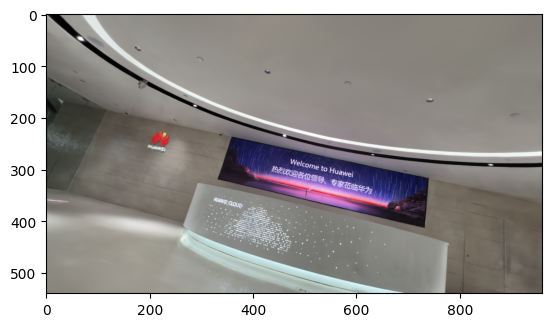

In [ ]:
plt.imshow(jacobians[0].cpu().numpy().transpose(1,2,0))

In [ ]:
means2D.shape

torch.Size([1441607, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


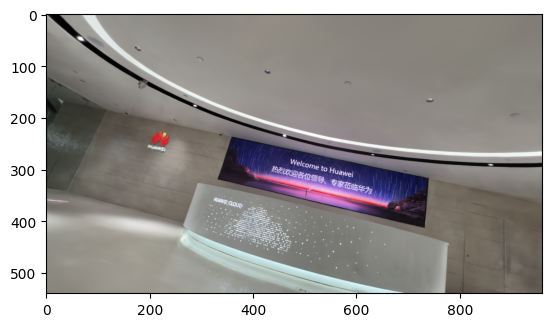

In [ ]:
plt.imshow(img_render['render'].detach().cpu().numpy().transpose(1,2,0))